### Given the scarcity of data in this task, we will use k-Fold cross-validation for training with k set to a large value to make a good use of the available data of a significantly small size.

#### Following are the hyperparameters that can be tuned for a neural network

1. learning rate
2. no of hidden units
3. no of epochs to train
4. dropout probability
5. loss function (NOT TUNED HERE)
6. mini batch size
7. weights initialization (NOT TUNED HERE)
8. l1/ l2 regularizers
9. activation function to use at the nodes (NOT TUNED HERE)
10. no of layers (NOT TUNED HERE)
11. learning rate decay (NOT TUNED HERE)
12. optimizer (NOT TUNED HERE)
13. momentum (only if sgd or rmsprop optimizer used, not with adam, adagrad)
14. momentum_dampening (only if sgd or rmsprop optimizer used, not with adam, adagrad) (NOT TUNED HERE)


There are several methods to tune hyperparameters of a neural network. Two of them are grid search and randomized search that select points in the parameter space and evaluate these points (each point is essestially a unique configuration of hyperparameters in the hyperparameter space) and return the best hyperparameter combination based on the performace on the validation data.

#### How is grid search/ randomized search done with k-fold cross validation?
1. Select n points in the hyperparameter space. For each point, do:
    a. Each point corresponds to a hyperparameter configuration in the hyperparameter space.
    b. Train and evaluate this model k times as follows.
        i. Randomly divide the training data into k partitions. Call them partition 1, partition 2,.........., partition k.
        ii. Repeat for each partition j starting from j = 1 to j = k
            . Train the model with this hyperparameter configuration on the partitions except partition j and test on                     partition j.
            . Store the performance of the model.
        iii. Calculate the average performance of the model with this hyperparameter configuration over the k folds.
2. Declare the model that was trained using the hyperparameters corresponding to the point that achieved the best              validation result as the best model and declare this choice of hyperparameters as the best hyperparameters.
3. Predict the labels of the testing data using this model.

## Import Libraries

In [44]:
import time
import copy
import sys
import os
from math import sqrt


import numpy as np

import pandas as pd

import seaborn as sns

import sklearn
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from skorch import NeuralNetRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [45]:
print("The python version used is {}".format(sys.version))
print("The torch version used is {}".format(torch.__version__))
print("The sklearn version used is {}".format(sklearn.__version__))

The python version used is 3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)]
The torch version used is 1.4.0
The sklearn version used is 0.20.3


## Import Data

In [46]:
training_data = pd.read_csv("normalized_training_features_and_targets.csv", sep = ",")
training_data.head()

,% of Cr,% of Hf,% of Mo,% of Nb,% of Ta,% of Ti,% of V,% of Zr,% of Ni,% of Al,% of Mn,%Cu,%C,Entropy,Hardness
0,0.0,0.0,0.0000,0.470,0.44,0.97491,0.0000,0.992366,0.000000,0.138686,0.0,0.0,0.0,0.602527,0.429768
1,0.0,0.0,0.7500,0.200,0.25,0.00000,0.4000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.589731,0.539457
2,0.0,0.0,0.5815,0.000,0.00,0.00000,0.4026,0.000000,0.396171,0.000000,0.0,0.0,0.0,0.733380,0.559966
3,0.0,0.0,0.5000,0.800,0.25,0.00000,0.4000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.541151,0.351534
4,0.0,0.0,0.0000,0.468,0.33,0.97491,0.0860,1.000000,0.000000,0.138686,0.0,0.0,0.0,0.741308,0.441290


In [47]:
num_features = len( training_data.iloc[0,:] ) - 1
print("The number of features is {}".format(num_features))
X_training = training_data.iloc[:,0:num_features]

X_training.head()

The number of features is 14


,% of Cr,% of Hf,% of Mo,% of Nb,% of Ta,% of Ti,% of V,% of Zr,% of Ni,% of Al,% of Mn,%Cu,%C,Entropy
0,0.0,0.0,0.0000,0.470,0.44,0.97491,0.0000,0.992366,0.000000,0.138686,0.0,0.0,0.0,0.602527
1,0.0,0.0,0.7500,0.200,0.25,0.00000,0.4000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.589731
2,0.0,0.0,0.5815,0.000,0.00,0.00000,0.4026,0.000000,0.396171,0.000000,0.0,0.0,0.0,0.733380
3,0.0,0.0,0.5000,0.800,0.25,0.00000,0.4000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.541151
4,0.0,0.0,0.0000,0.468,0.33,0.97491,0.0860,1.000000,0.000000,0.138686,0.0,0.0,0.0,0.741308


In [48]:
Y_training = pd.DataFrame(training_data["Hardness"])
Y_training.head()

,Hardness
0,0.429768
1,0.539457
2,0.559966
3,0.351534
4,0.441290


## Initialize Seeds for Reproducibility

In [49]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

device_to_use = "cuda" if torch.cuda.device_count() > 0 else "cpu"

## torch Regression Model definition

In [50]:
class Regression_Module(nn.Module):
    def __init__(self, num_units = 10, dropout = 0.5, activation = F.leaky_relu, input_dim = num_features, output_dim = 1):
           
        
        super(Regression_Module, self).__init__()
        self.activation = activation
        
        
        self.L1 = nn.Linear(input_dim, num_units)
        self.L2 = nn.Linear(num_units, num_units)
        
        #self.batchnorm_1 = nn.BatchNorm1d(num_units, 1e-12, affine=True, track_running_stats=True)
        self.dropout_1 = nn.Dropout(p=dropout)
        
        self.L3 = nn.Linear(num_units, num_units)
        self.L4 = nn.Linear(num_units, num_units)
        
        #self.batchnorm_2 = nn.BatchNorm1d(num_units, 1e-12, affine=True, track_running_stats=True)
        self.dropout_2 = nn.Dropout(p=dropout)
        
        self.L5 = nn.Linear(num_units, num_units)
        self.L6 = nn.Linear(num_units, output_dim)



    def forward(self, input):
            
        input = self.activation(self.L1(input.float()))
        input = self.L2(input.float())

        # input = input.unsqueeze(0) #https://discuss.pytorch.org/t/batchnorm1d-valueerror-expected-2d-or-3d-input-got-1d-input/42081
        # input = self.batchnorm_1(input)

        input = self.activation(input.float())
        input = self.dropout_1(input.float())

        input = self.activation(self.L3(input.float()))
        input = self.L4(input.float())

        # input = input.unsqueeze(0)
        # input = self.batchnorm_2(input)

        input = self.activation(input.float())
        input = self.dropout_2(input.float())

        input = self.activation(self.L5(input.float()))

        input = self.L6(input.float())


        #VVI: need to return in double format instead of a float
        return input.double()

## skorch Regression Model definition
Takes torch regressor as an argument.

In [51]:
skorch_regressor = NeuralNetRegressor(module = Regression_Module,  #pass a torch module class
                                      device = device_to_use,
                                      iterator_train__shuffle = True,
                                      
                                     ) 
                                      

## Generate hyperparameters for hyperparameter tuning using sklearn's Randomized Search


In [57]:
#lr = np.random.uniform(low = 0.000001,high = 0.05, size = 20).tolist()
lr = [0.00005, 0.0001, 0.0003, 0.0005, 0.001, 0.003, 0.005]

weight_decay_for_regularization = [1e-5, 5e-5, 1e-4, 5e-5, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]      #weight decay equals L2 regularization for SGD

momentum_vals = [0.5, 0.75, 0.99]

momentum_dampening = [0.]

nesterov = [True, False]

no_of_nodes_per_layer = [num_features, num_features * int(1.25), num_features * int(1.5), num_features * int(1.75), num_features *2]

#max_epochs = [epoch_num for epoch_num in range(25, 400, 25)]
max_epochs = [50, 75, 100, 125, 150, 175, 200, 250, 300]

dropout_probability_per_node = [0., 0.3, 0.5]

#We will use onle mse as the loss function for now. so skip tuning the loss function.

minibatch_size = [8, 16, 32, 64] #should always be less than the size of the trianing set

#optimizers = [torch.optim.SGD, torch.optim.RMSprop, torch.optim.Adagrad]
optimizers = [torch.optim.SGD] #Using only SGD

#### Create the grid for selection of random points on the hyperparameter space.


In [58]:
common_param_grid = {
    
    "lr" : lr,
    "max_epochs" : max_epochs,
    
    
    
    #list all the formal arguments of the torch module that u pass to skorch regressor here beginning with module__
    "module__num_units" : no_of_nodes_per_layer,
    "module__dropout" : dropout_probability_per_node,
    #not passing the activation here though
    
    
    
    "optimizer" : optimizers,
    "optimizer__weight_decay": weight_decay_for_regularization,
    "optimizer__momentum" : momentum_vals,
    "optimizer__dampening" : momentum_dampening,
    "optimizer__nesterov" : nesterov, 
    
    
    
    "iterator_train__batch_size": minibatch_size,
    #"callbacks__scheduler__epoch": [10, 50, 100], #learning rate scheduler    
}

#### Create a Randomized Search Instance and pass the estimator, thehyperparameters' grid, the no of random samples to take from the grid, and the value of k for k-Fold cross-validation.

In [62]:
sgd_randomized_search = RandomizedSearchCV(estimator = skorch_regressor,
                                          scoring = "neg_mean_squared_error",
                                          param_distributions = common_param_grid,
                                          n_iter = 150,  #no of random samples to take from the grid                                                    
                                          cv = 10,
                                          )

#skorch_regressor.get_params().keys()

### Train the models.

In [63]:
assert len(X_training) == len(Y_training)
randomized_search_result = sgd_randomized_search.fit(X_training.values, Y_training.values)

#dataframe.values gives the underlying numpy array of the data frame, doing this conversion since pandas data frame 
#is not supported.

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.6099        0.5296  0.0070
      2        0.6088        0.5259  0.0079
      3        0.6058        0.5215  0.0090
      4        0.5984        0.5169  0.0080
      5        0.6032        0.5122  0.0090
      6        0.6010        0.5073  0.0080
      7        0.5885        0.5026  0.0091
      8        0.5852        0.4978  0.0080
      9        0.5852        0.4930  0.0090
     10        0.5707        0.4884  0.0080
     11        0.5652        0.4837  0.0079
     12        0.5649        0.4792  0.0080
     13        0.5526        0.4746  0.0080
     14        0.5552        0.4701  0.0090
     15        0.5495        0.4657  0.0100
     16        0.5392        0.4612  0.0090
     17        0.5449        0.4569  0.0090
     18        0.5309        0.4525  0.0080
     19        0.5261        0.4483  0.0090
     20        0.5248        0.4440  0.0100
     21        0.5149        0.4

    138        0.1957        0.1491  0.0080
    139        0.1931        0.1479  0.0090
    140        0.1960        0.1466  0.0090
    141        0.1915        0.1453  0.0110
    142        0.1932        0.1441  0.0080
    143        0.1919        0.1428  0.0090
    144        0.1860        0.1416  0.0090
    145        0.1865        0.1404  0.0090
    146        0.1854        0.1392  0.0080
    147        0.1820        0.1380  0.0090
    148        0.1815        0.1368  0.0080
    149        0.1836        0.1357  0.0090
    150        0.1805        0.1345  0.0080
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.2053        0.2857  0.0060
      2        0.2015        0.2841  0.0110
      3        0.1987        0.2822  0.0080
      4        0.2019        0.2803  0.0080
      5        0.1957        0.2783  0.0110
      6        0.1916        0.2762  0.0100
      7        0.1910        0.2742  0.0090
      8        0.1905        0.2

    129        0.0870        0.1322  0.0080
    130        0.0874        0.1316  0.0070
    131        0.0843        0.1310  0.0080
    132        0.0872        0.1304  0.0080
    133        0.0851        0.1298  0.0080
    134        0.0814        0.1292  0.0100
    135        0.0851        0.1287  0.0090
    136        0.0828        0.1281  0.0080
    137        0.0830        0.1275  0.0080
    138        0.0807        0.1270  0.0090
    139        0.0818        0.1264  0.0100
    140        0.0835        0.1259  0.0100
    141        0.0803        0.1254  0.0080
    142        0.0837        0.1248  0.0090
    143        0.0807        0.1243  0.0100
    144        0.0844        0.1238  0.0090
    145        0.0785        0.1233  0.0090
    146        0.0794        0.1228  0.0080
    147        0.0795        0.1223  0.0080
    148        0.0770        0.1218  0.0080
    149        0.0802        0.1213  0.0080
    150        0.0790        0.1208  0.0080
  epoch    train_loss    valid_l

      4        0.2533        0.3478  0.0139
      5        0.2590        0.3450  0.0140
      6        0.2447        0.3416  0.0140
      7        0.2509        0.3377  0.0140
      8        0.2406        0.3333  0.0140
      9        0.2398        0.3285  0.0140
     10        0.2330        0.3232  0.0150
     11        0.2357        0.3176  0.0130
     12        0.2302        0.3116  0.0130
     13        0.2214        0.3053  0.0140
     14        0.2173        0.2987  0.0140
     15        0.2107        0.2918  0.0140
     16        0.2036        0.2848  0.0140
     17        0.2018        0.2775  0.0150
     18        0.1949        0.2701  0.0160
     19        0.1868        0.2625  0.0160
     20        0.1831        0.2548  0.0140
     21        0.1762        0.2470  0.0140
     22        0.1716        0.2391  0.0160
     23        0.1601        0.2312  0.0199
     24        0.1548        0.2234  0.0229
     25        0.1510        0.2156  0.0219
     26        0.1464        0.2

c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


     10        0.1778        0.2032  0.0200
     11        0.1733        0.1984  0.0189
     12        0.1694        0.1934  0.0190
     13        0.1641        0.1882  0.0189
     14        0.1587        0.1828  0.0200
     15        0.1541        0.1772  0.0189
     16        0.1483        0.1716  0.0180
     17        0.1427        0.1659  0.0190
     18        0.1374        0.1602  0.0189
     19        0.1321        0.1544  0.0189
     20        0.1264        0.1488  0.0189
     21        0.1211        0.1431  0.0189
     22        0.1159        0.1376  0.0180
     23        0.1102        0.1322  0.0189
     24        0.1050        0.1269  0.0189
     25        0.1006        0.1218  0.0180
     26        0.0959        0.1168  0.0189
     27        0.0913        0.1120  0.0180
     28        0.0865        0.1075  0.0189
     29        0.0825        0.1032  0.0189
     30        0.0784        0.0991  0.0189
     31        0.0748        0.0952  0.0180
     32        0.0713        0.0

### Save and view the best parameters and hyperparameters obtained from randomized search.

In [77]:
# randomized_search_result.best_estimator_ gives the neural net with best parameters
# randomized_search_result.best_params_ gives the best hyperparameters that were used to get this best estimator

#saving the best estimator i.e., the neural network parameters
joblib.dump(randomized_search_result.best_estimator_, 'best_params_of_NN_by_randomized_search.pkl', compress = 1)

#saving the best hyperparameters
joblib.dump(randomized_search_result.best_params_, 'best_hyperparams_for_NN_by_randomized_search.pkl', compress = 1)

randomized_search_result.best_params_

c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


{'optimizer__weight_decay': 5e-05,
 'optimizer__nesterov': False,
 'optimizer__momentum': 0.99,
 'optimizer__dampening': 0.0,
 'optimizer': torch.optim.sgd.SGD,
 'module__num_units': 14,
 'module__dropout': 0.5,
 'max_epochs': 125,
 'lr': 0.0001,
 'iterator_train__batch_size': 32}

In [78]:
def report(results, num_of_top_results_to_report = 5):
    #this utility method was found online.
    
    for idx in range(0, num_of_top_results_to_report):
        candidates = np.flatnonzero(results['rank_test_score'] == idx)
        for candidate in candidates:
            print("Model with rank: {0}".format(idx))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [79]:
report(sgd_randomized_search.cv_results_,num_of_top_results_to_report = 3)

Model with rank: 1
Mean validation score: -0.079 (std: 0.030)
Parameters: {'optimizer__weight_decay': 5e-05, 'optimizer__nesterov': False, 'optimizer__momentum': 0.99, 'optimizer__dampening': 0.0, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'module__num_units': 14, 'module__dropout': 0.5, 'max_epochs': 125, 'lr': 0.0001, 'iterator_train__batch_size': 32}

Model with rank: 2
Mean validation score: -0.124 (std: 0.036)
Parameters: {'optimizer__weight_decay': 0.005, 'optimizer__nesterov': False, 'optimizer__momentum': 0.5, 'optimizer__dampening': 0.0, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'module__num_units': 14, 'module__dropout': 0.5, 'max_epochs': 150, 'lr': 0.001, 'iterator_train__batch_size': 64}



### Visualize training and validation loss

In [80]:
# get training and validation loss
epochs = [i for i in range(len(sgd_randomized_search.best_estimator_.history))]
training_loss = sgd_randomized_search.best_estimator_.history[:,'train_loss']
validation_loss = sgd_randomized_search.best_estimator_.history[:,'valid_loss']

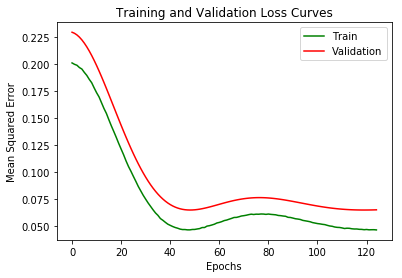

In [81]:
plt.plot(epochs,training_loss,'g-');
plt.plot(epochs,validation_loss,'r-');
plt.title('Training and Validation Loss Curves');
plt.xlabel('Epochs');
plt.ylabel('Mean Squared Error');
plt.legend(['Train','Validation']);

## Test on Test Data

In [82]:
# Predict on test data
testing_data = pd.read_csv("normalized_testing_features_and_targets.csv", sep = ",")
testing_data.head()

,% of Cr,% of Hf,% of Mo,% of Nb,% of Ta,% of Ti,% of V,% of Zr,% of Ni,% of Al,% of Mn,%Cu,%C,Entropy,Hardness
0,0.0,1.0,0.000,0.666667,0.500,0.8,0.000000,0.8,0.0,0.0,0.0,0.0,0.0,0.667795,0.296870
1,0.0,0.0,0.500,1.000000,0.250,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.354613,0.462085
2,0.0,0.0,1.000,0.666667,0.500,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.527139,0.893030
3,0.0,0.0,0.000,0.833333,0.000,1.0,0.833333,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.296870
4,0.0,0.0,0.625,0.833333,0.625,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.489351


In [83]:
# Separate features and targets
X_testing = testing_data.iloc[:,0:num_features].values #notice retaining only the underlying numpy arrays
Y_testing = pd.DataFrame(testing_data["Hardness"]).values

Y_predictions_on_test_data = sgd_randomized_search.best_estimator_.predict(X_testing.astype(np.float32))

In [84]:
Y_testing

array([[0.29686996],
       [0.46208454],
       [0.89303001],
       [0.29686996],
       [0.4893514 ],
       [1.        ],
       [0.98693127],
       [0.09035173],
       [0.56082607],
       [0.87011939],
       [0.62003872],
       [0.        ]])

In [85]:
Y_predictions_on_test_data

array([[0.47764346],
       [0.4777196 ],
       [0.47785416],
       [0.47773674],
       [0.4778147 ],
       [0.47785121],
       [0.47786573],
       [0.47772494],
       [0.47774139],
       [0.47786519],
       [0.47779754],
       [0.47778457]])

In [86]:
# get Root Mean Squared Error
MSE(Y_testing,Y_predictions_on_test_data)**(1/2)

0.3328240970917553

In [87]:
# Kernel Density Estimation Plot

# sns.kdeplot(Y_predictions_on_test_data.squeeze(), label='predictions of the model', shade=True)
# sns.kdeplot(Y_testing.squeeze(), label='true values', shade=True)
# plt.xlabel('Hardness');

In [88]:
# Dist Plot

# sns.distplot(Y_testing.squeeze()-Y_predictions_on_test_data.squeeze(),label='error', bins = 10);
# plt.xlabel('Error');

-0.04516772582523787


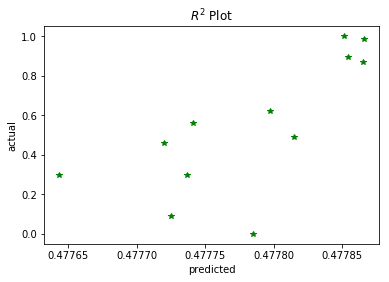

In [89]:
# R^2 plot

print(r2_score(Y_testing,Y_predictions_on_test_data))

plt.plot(Y_predictions_on_test_data,Y_testing,'g*')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('$R^{2}$ Plot');

#### View the actual values vs predicted values in real scale

In [90]:
#The maximum and minimum targets of the training data were [983.91] and [116.] from feature engineering file

max_hardness = 983.91
min_hardness = 116.

def convert_to_original_scale(scaled_hardness):
    original_scale_hardness = (scaled_hardness * (max_hardness - min_hardness)) + min_hardness
    return original_scale_hardness

for test_sample in range(len(Y_predictions_on_test_data)):
    print("True Hardness: {}".format(convert_to_original_scale(Y_testing[test_sample])))
    print("Predicted Hardness: {}".format(convert_to_original_scale(Y_predictions_on_test_data[test_sample])))
    print("")

True Hardness: [373.65640529]
Predicted Hardness: [530.5515354]

True Hardness: [517.04779606]
Predicted Hardness: [530.61762235]

True Hardness: [891.0696757]
Predicted Hardness: [530.73440614]

True Hardness: [373.65640529]
Predicted Hardness: [530.63249515]

True Hardness: [540.71297677]
Predicted Hardness: [530.7001599]

True Hardness: [983.91]
Predicted Hardness: [530.73184543]

True Hardness: [972.56751694]
Predicted Hardness: [530.74444204]

True Hardness: [194.41716683]
Predicted Hardness: [530.62225231]

True Hardness: [602.74655695]
Predicted Hardness: [530.6365302]

True Hardness: [871.18532268]
Predicted Hardness: [530.74397646]

True Hardness: [654.13780736]
Predicted Hardness: [530.68526124]

True Hardness: [116.]
Predicted Hardness: [530.67400965]

